In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from matplotlib.ticker import MaxNLocator
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans

In [3]:
#Fonts 
from matplotlib.font_manager import FontProperties
font = FontProperties(fname='../public/media/fonts/kr/NanumGothic-Regular.ttf')

In [4]:
kr_dfc = pd.read_csv('./KR_Corp_Waste.csv', encoding='cp949')

In [5]:
kr_dfc.head()

,기초시군구(관할관청),업체명,연락처,폐기물구분,폐기물명,연간배출량(톤)
0,강원특별자치도 강릉시,(주)기성환경,033-655-6969,사업장배출시설계폐기물,그 밖의 폐목재류,250.83
1,강원특별자치도 강릉시,(주)기성환경,033-655-6969,사업장배출시설계폐기물,폐합성수지류(폐염화비닐수지류는 제외한다),219.17
2,강원특별자치도 강릉시,(주)에코비트워터(강릉하수처리장),033-650-5200,사업장배출시설계폐기물,그 밖의 공정오니(무기성),0.00
3,강원특별자치도 강릉시,(주)에코비트워터(강릉하수처리장),033-650-5200,사업장배출시설계폐기물,그 밖의 유기성오니,0.00
4,강원특별자치도 강릉시,(주)에코비트워터(강릉하수처리장),033-650-5200,사업장배출시설계폐기물,그 밖의 폐기물,0.00


In [6]:
df_cluster = kr_dfc[['기초시군구(관할관청)', '연간배출량(톤)']].copy()

In [7]:
# Cleaning the dataset 
kr_dfc.isnull().sum()

기초시군구(관할관청)       0
업체명               0
연락처             480
폐기물구분          6639
폐기물명              0
연간배출량(톤)          0
dtype: int64

In [8]:
df_cleaned = kr_dfc.dropna().copy()
df_cleaned_cols = kr_dfc.dropna(axis=1).copy()

In [9]:
df_cleaned.isnull().sum()

기초시군구(관할관청)    0
업체명            0
연락처            0
폐기물구분          0
폐기물명           0
연간배출량(톤)       0
dtype: int64

In [10]:
company_max_values = (
    df_cleaned.groupby("기초시군구(관할관청)")["연간배출량(톤)"]
    .max()
    .reset_index()
    .sort_values(by="연간배출량(톤)", ascending=True)  # Sort from min to max
)

for index, row in company_max_values.iterrows():
    print(f"City: {row['기초시군구(관할관청)']}, Max Emission: {row['연간배출량(톤)']:.2f} tons")

City: 경기도 부천시, Max Emission: 1.69 tons
City: 경기도 안산시 상록구, Max Emission: 3.31 tons
City: 전라남도 강진군, Max Emission: 12.85 tons
City: 경기도 안산시 단원구, Max Emission: 24.54 tons
City: 경기도 부천시 대산동, Max Emission: 36.35 tons
City: 경상북도 봉화군, Max Emission: 45.07 tons
City: 경기도 안양시 만안구, Max Emission: 66.24 tons
City: 서울특별시 종로구, Max Emission: 86.50 tons
City: 서울특별시 강동구, Max Emission: 93.91 tons
City: 대구광역시 남구, Max Emission: 95.70 tons
City: 강원특별자치도 고성군, Max Emission: 96.00 tons
City: 부산광역시 중구, Max Emission: 96.12 tons
City: 광주경제자유구역청, Max Emission: 99.21 tons
City: 부산광역시 동래구, Max Emission: 112.42 tons
City: 경기도 부천시 성곡동, Max Emission: 117.58 tons
City: 부산광역시 수영구, Max Emission: 129.88 tons
City: 충청북도 청주시 상당구, Max Emission: 142.11 tons
City: 대구광역시 중구, Max Emission: 145.77 tons
City: 인천광역시 연수구, Max Emission: 146.68 tons
City: 경상남도 마산시, Max Emission: 154.11 tons
City: 경기도 부천시 신중동, Max Emission: 157.44 tons
City: 서울특별시 구로구, Max Emission: 161.27 tons
City: 대구광역시 군위군, Max Emission: 175.67 tons
City: 부산광역시 금정구, 

In [11]:
#define the company name and filter 
city_name = "경상북도 포항시 남구"

city_result = company_max_values.loc[company_max_values["기초시군구(관할관청)"] == city_name]

if not city_result.empty:
    print(f"City: {city_result.iloc[0]['기초시군구(관할관청)']}, Max Emission: {city_result.iloc[0]['연간배출량(톤)']:.2f} tons")
else:
    print(f"City '{city_name}' not found in the dataset")

City: 경상북도 포항시 남구, Max Emission: 164806.12 tons


In [12]:
df_clusterC = df_cleaned[['기초시군구(관할관청)', '연간배출량(톤)']].copy()

In [13]:
df_clusterC.head(5)

,기초시군구(관할관청),연간배출량(톤)
0,강원특별자치도 강릉시,250.83
1,강원특별자치도 강릉시,219.17
2,강원특별자치도 강릉시,0.00
3,강원특별자치도 강릉시,0.00
4,강원특별자치도 강릉시,0.00


In [14]:
city_names = df_clusterC['기초시군구(관할관청)']  

# Scale only the numerical column
scaler = StandardScaler()
df_scaledC = scaler.fit_transform(df_clusterC[['연간배출량(톤)']])  

# Perform clustering
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_scaledC)  # Get cluster assignments

# Create DataFrame with city names and cluster results
df_clusterC_final = pd.DataFrame({
    '기초시군구(관할관청)': city_names,
    '연간배출량(톤)': df_clusterC['연간배출량(톤)'],  # Original values
    'Cluster': clusters
})

# Print the first few rows
print(df_clusterC_final.head())

   기초시군구(관할관청)  연간배출량(톤)  Cluster
0  강원특별자치도 강릉시    250.83        0
1  강원특별자치도 강릉시    219.17        0
2  강원특별자치도 강릉시      0.00        0
3  강원특별자치도 강릉시      0.00        0
4  강원특별자치도 강릉시      0.00        0


In [15]:
# Keep city names separate
city_names = df_clusterC['기초시군구(관할관청)']

In [16]:
scaler = StandardScaler()
df_scaledC = scaler.fit_transform(df_clusterC[['연간배출량(톤)']])

In [17]:
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_scaledC)

In [18]:
df_clusterC['Cluster'] = clusters  # Assign clusters to original DataFrame

df_clusterC_final = pd.DataFrame({
    '기초시군구(관할관청)': city_names,
    '연간배출량(톤)': df_clusterC['연간배출량(톤)'],  # Original values
    'Cluster': clusters
})

# Print the first few rows
print(df_clusterC_final.head())

   기초시군구(관할관청)  연간배출량(톤)  Cluster
0  강원특별자치도 강릉시    250.83        0
1  강원특별자치도 강릉시    219.17        0
2  강원특별자치도 강릉시      0.00        0
3  강원특별자치도 강릉시      0.00        0
4  강원특별자치도 강릉시      0.00        0


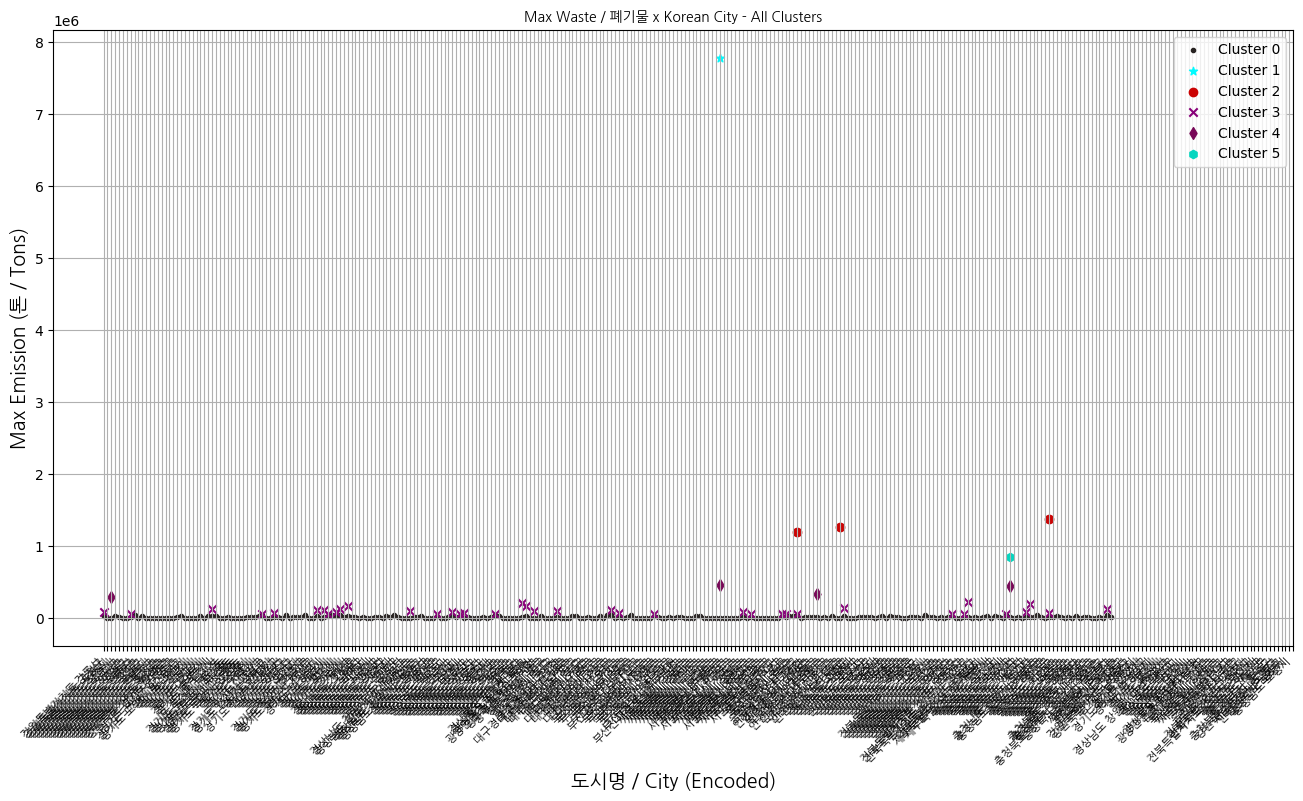

In [19]:

# Define markers and colors for each cluster
markers = ['.', '*', 'o', 'x', 'd', 'h']
colours = ['#272221', '#00fbff', '#cb0303', '#880079', '#780858', '#05d6c0']

plt.figure(figsize=(16, 8))

all_cities = []

for cluster_num in range(0, 6):
    cluster_data = df_clusterC[df_clusterC["Cluster"] == cluster_num]

    max_values_cluster = (
        cluster_data.groupby("기초시군구(관할관청)")["연간배출량(톤)"]
        .max()
        .reset_index()
    )

    cities_cluster = max_values_cluster["기초시군구(관할관청)"]
    max_waste_cluster = max_values_cluster["연간배출량(톤)"]

    all_cities.extend(cities_cluster)

    plt.scatter(cities_cluster, max_waste_cluster,
                label=f'Cluster {cluster_num}',
                marker=markers[cluster_num],
                color=colours[cluster_num])


plt.xlabel("도시명 / City (Encoded)", fontsize=14, fontproperties=font)
plt.ylabel("Max Emission (톤 / Tons)", fontsize=14, fontproperties=font)
plt.title("Max Waste / 폐기물 x Korean City - All Clusters", fontsize=14, fontproperties=font)

plt.legend()
plt.grid(True)

plt.xticks(ticks=range(len(all_cities)), labels=all_cities, fontproperties=font, fontsize=8, rotation=45, ha='right')
#plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
plt.show()

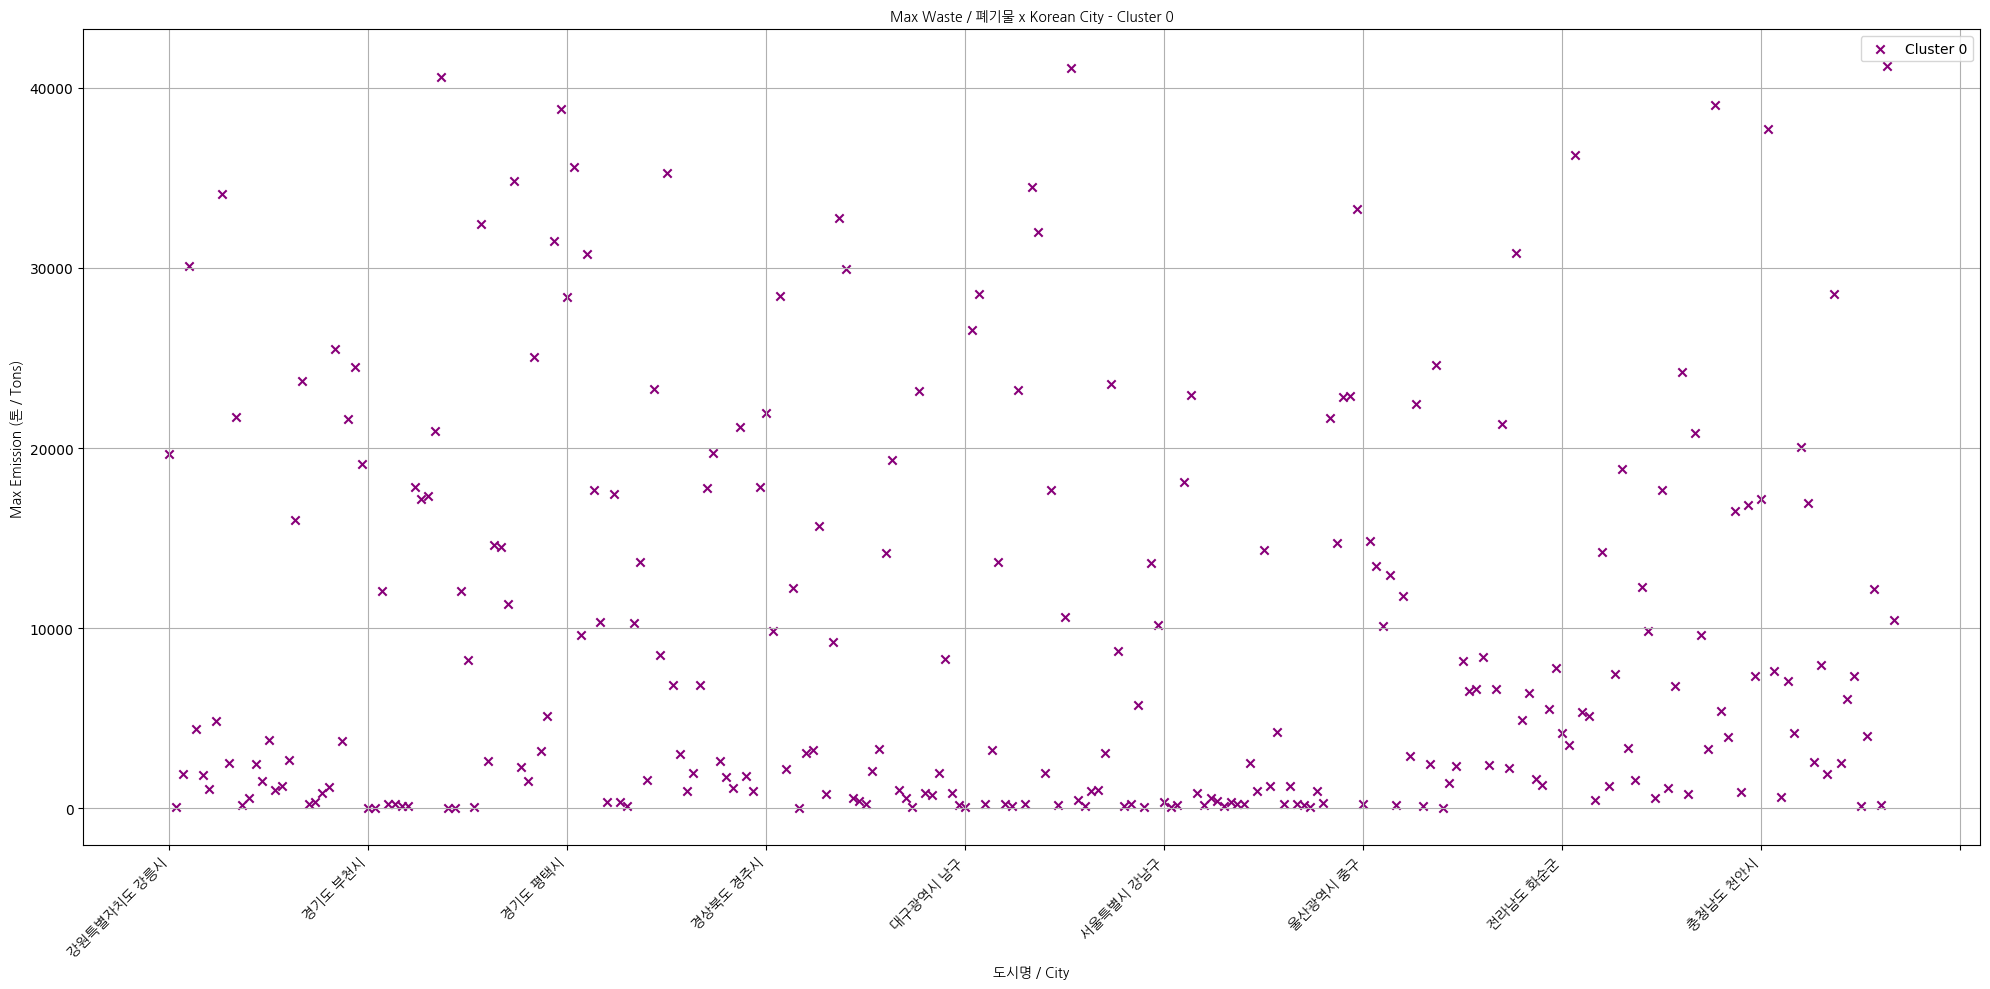

In [20]:
# Choose a single cluster to visualize (Change this number to the desired cluster)
selected_cluster = 0

# Filter data for only this cluster
cluster_data = df_clusterC[df_clusterC["Cluster"] == selected_cluster]

# Get max emission values for each city in the cluster
max_values_cluster = (
    cluster_data.groupby("기초시군구(관할관청)")["연간배출량(톤)"]
    .max()
    .reset_index()
)

cities_cluster = max_values_cluster["기초시군구(관할관청)"]
max_waste_cluster = max_values_cluster["연간배출량(톤)"]

# Scatter plot for the selected cluster
plt.figure(figsize=(20, 10))
plt.scatter(cities_cluster, max_waste_cluster, label=f'Cluster {selected_cluster}', 
            marker='x', color='#880079')

# Apply font and labels
plt.xlabel("도시명 / City", fontproperties=font)
plt.ylabel("Max Emission (톤 / Tons)", fontproperties=font)
plt.title(f"Max Waste / 폐기물 x Korean City - Cluster {selected_cluster}", fontproperties=font)
plt.legend()
plt.grid(True)


plt.xticks(ticks=range(len(cities_cluster)), labels=cities_cluster, fontproperties=font, fontsize=10, rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
plt.tight_layout()
plt.show()


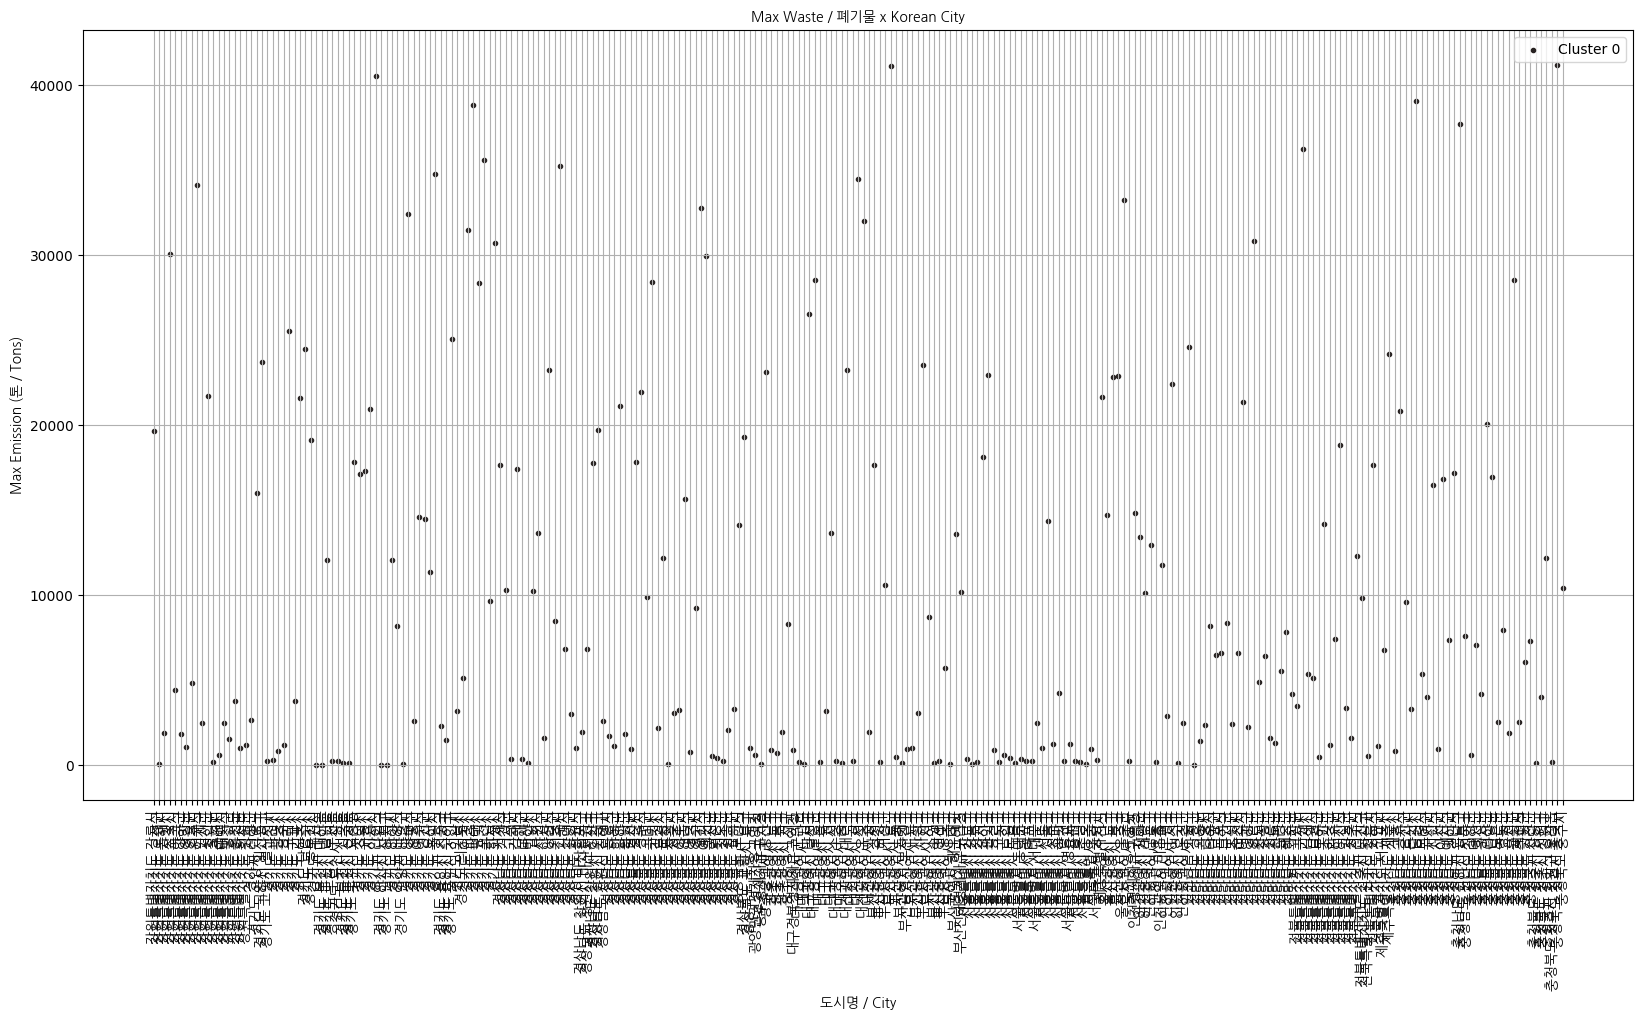

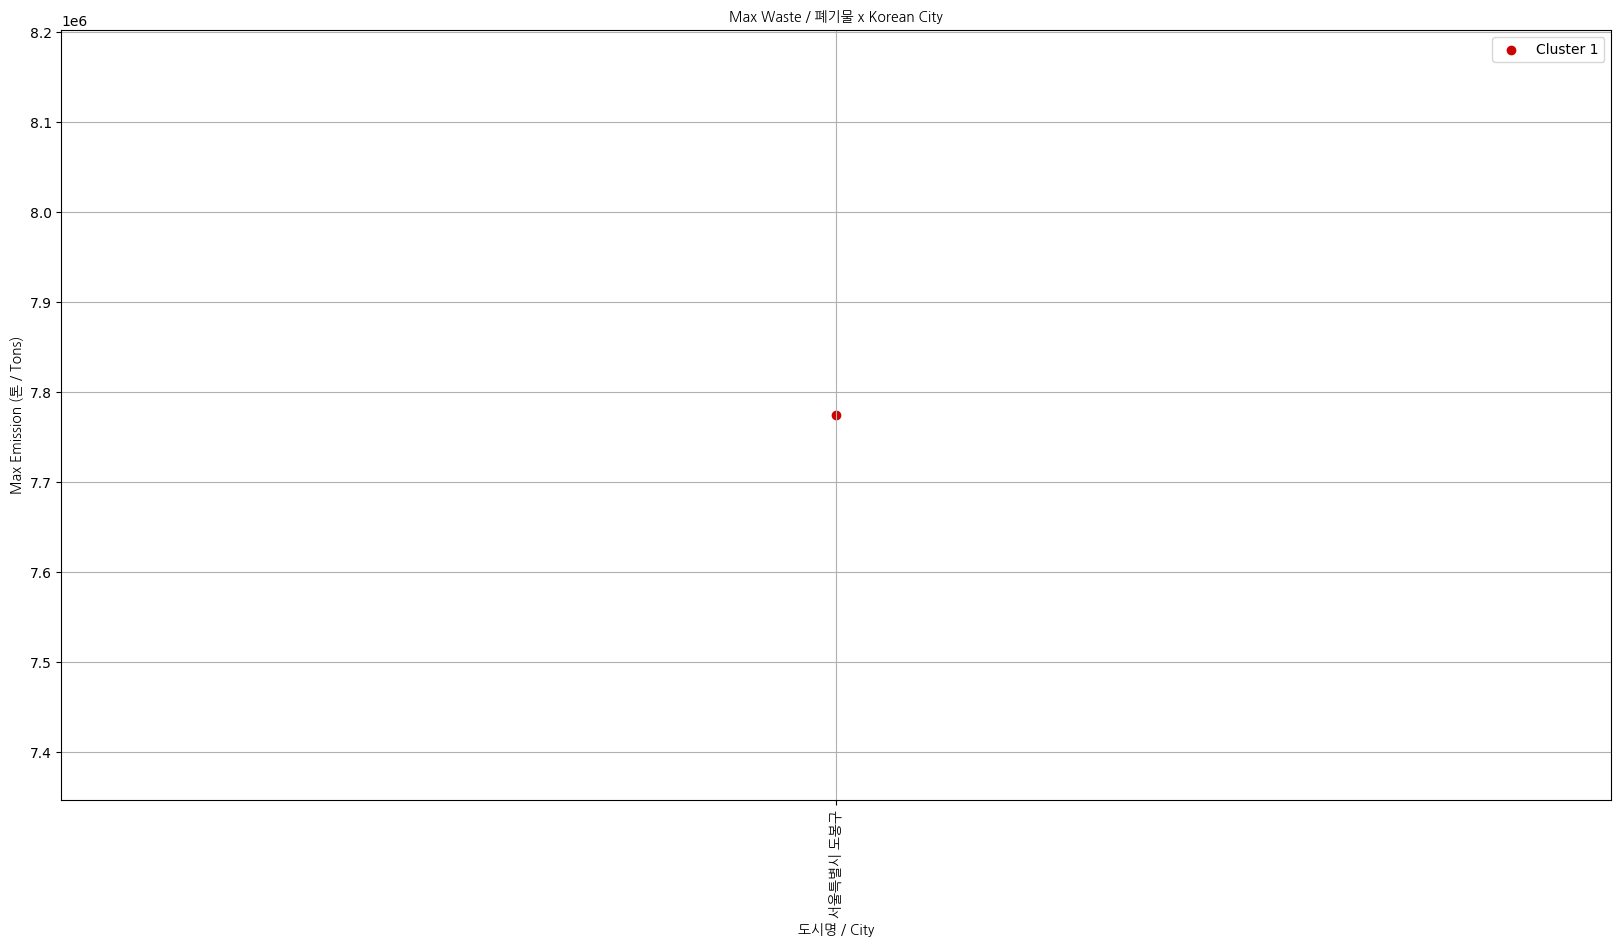

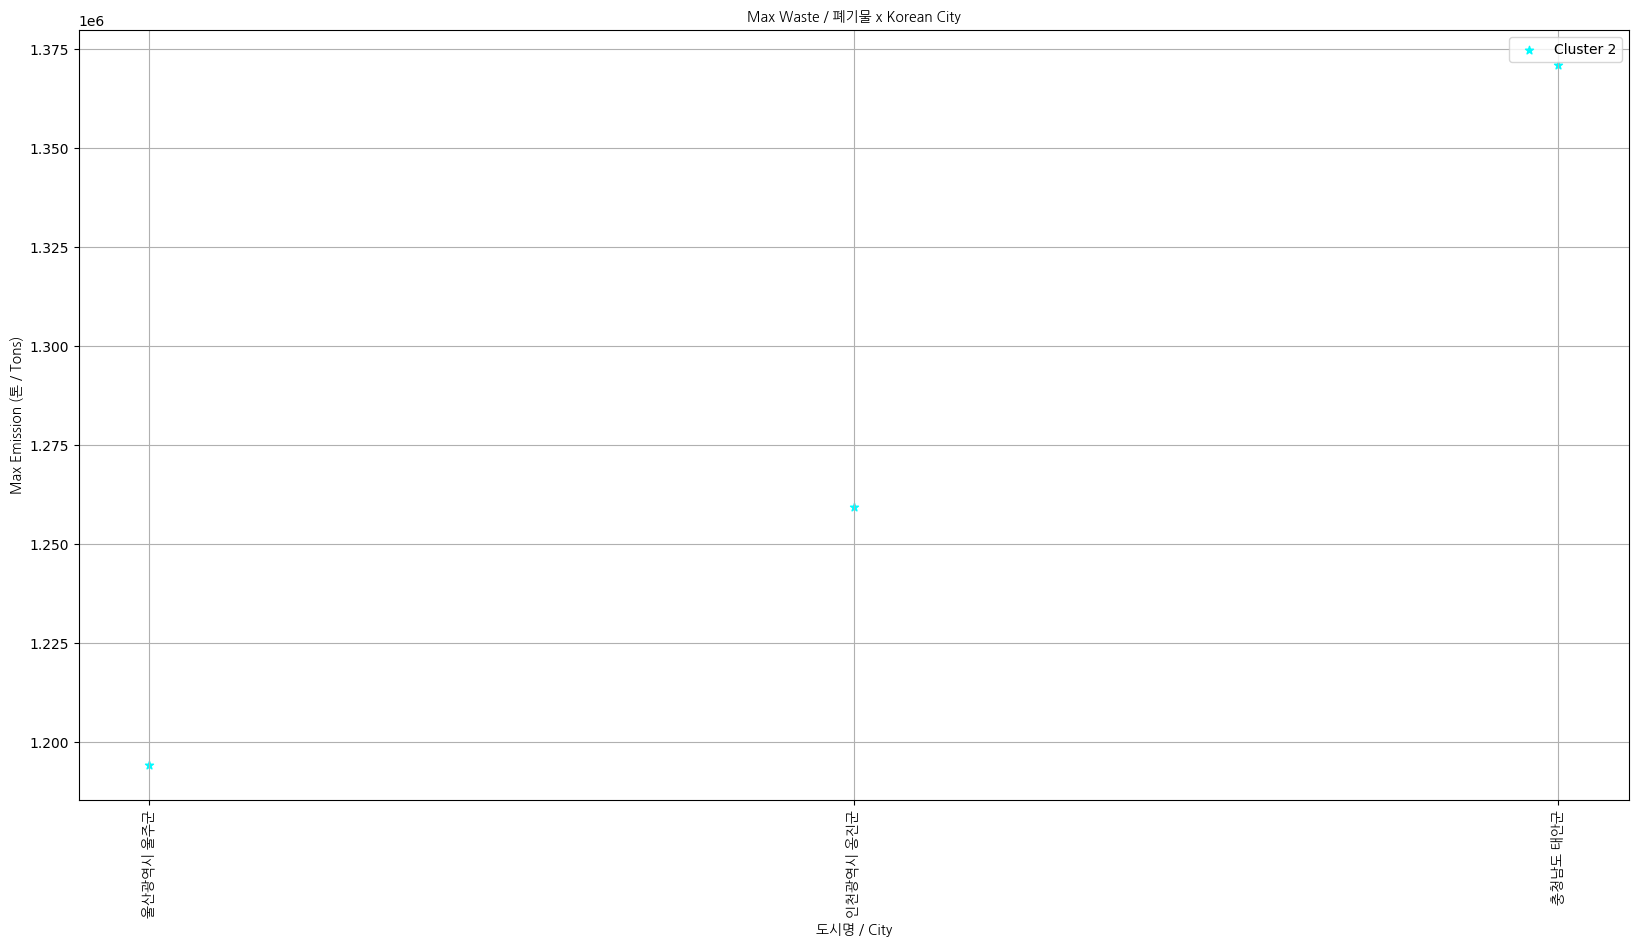

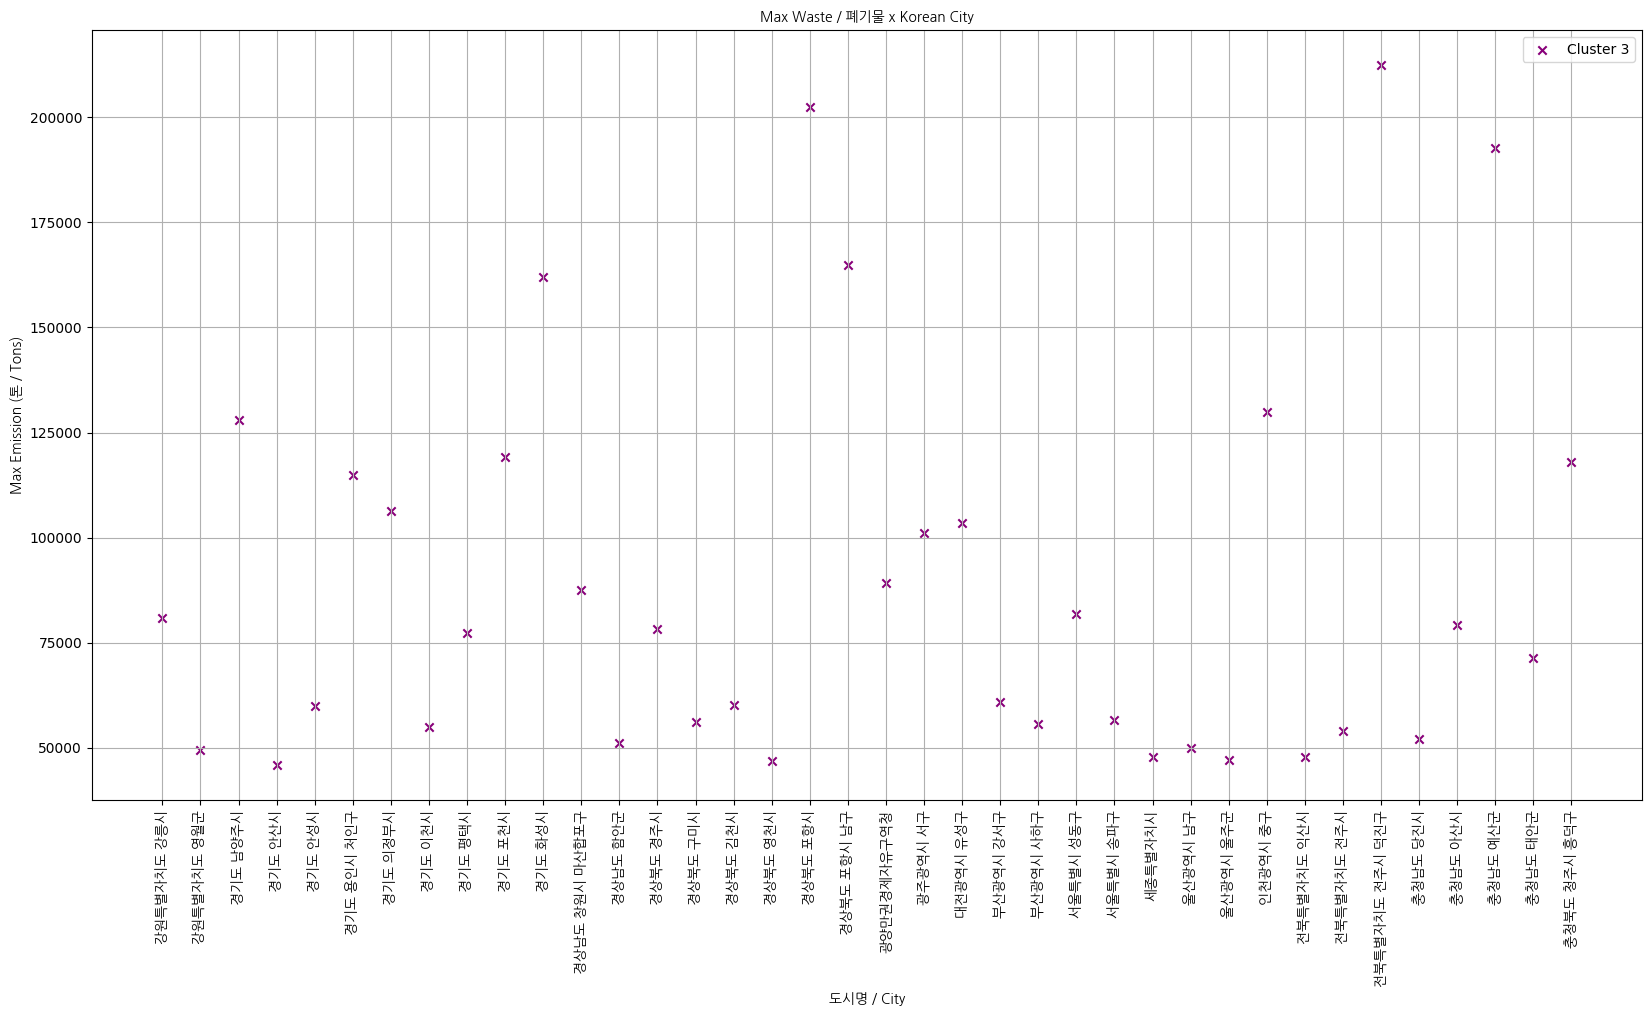

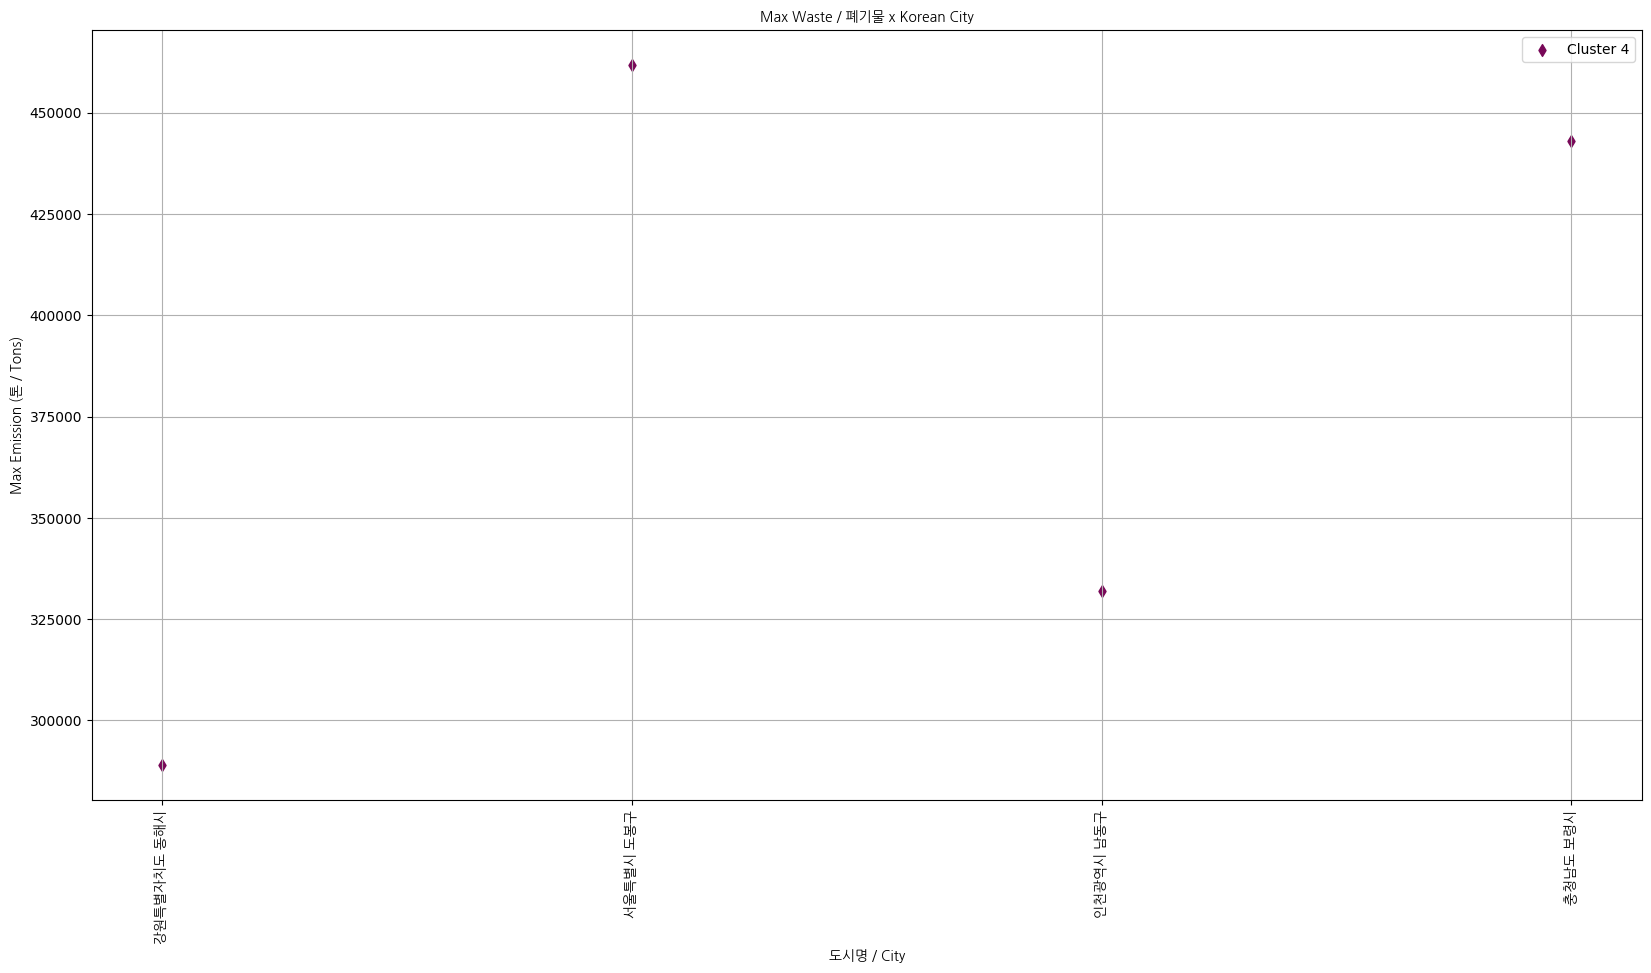

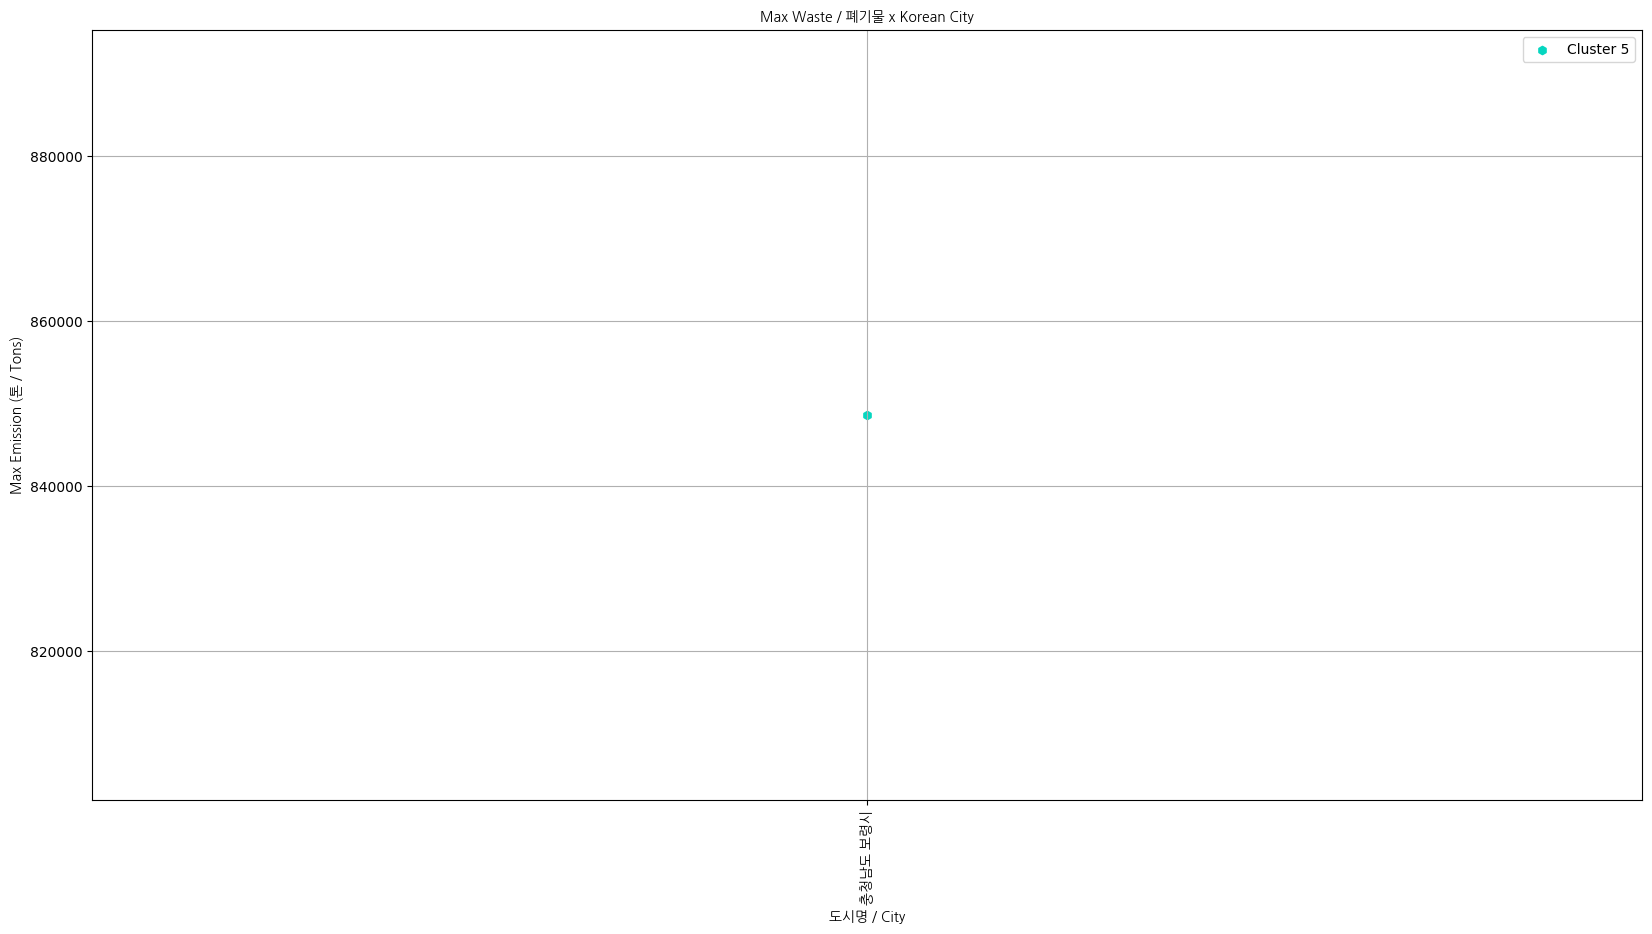

In [21]:
markers = ['.', 'o', '*', 'x', 'd', 'h']
colours = ['#272221', '#cb0303', '#00fbff', '#880079', '#780858', '#05d6c0']

for cluster_num in range(0,6):
    cluster_data = df_clusterC[df_clusterC["Cluster"] == cluster_num]

    max_values_cluster = (
        cluster_data.groupby("기초시군구(관할관청)")["연간배출량(톤)"]
        .max()
        .reset_index()
    )

    #Extract values
    cities_cluster = max_values_cluster["기초시군구(관할관청)"]
    max_waste_cluster = max_values_cluster["연간배출량(톤)"]

    plt.figure(figsize=(20, 10))

    #plt.scatter(cities_cluster, max_waste_cluster, label=f'Cluster {cluster_num}', color='#272221', marker='x')
    plt.scatter(cities_cluster, max_waste_cluster,label=f'Cluster {cluster_num}', marker=markers[cluster_num],color=colours[cluster_num])

    plt.xlabel("도시명 / City", fontproperties=font)
    plt.ylabel("Max Emission (톤 / Tons)", fontproperties=font)
    plt.title(f"Max Waste / 폐기물 x Korean City", fontproperties=font)
    plt.legend()
    plt.grid(True)
    plt.xticks(ticks=range(len(cities_cluster)), labels=cities_cluster, fontproperties=font, rotation=90)
    plt.show()

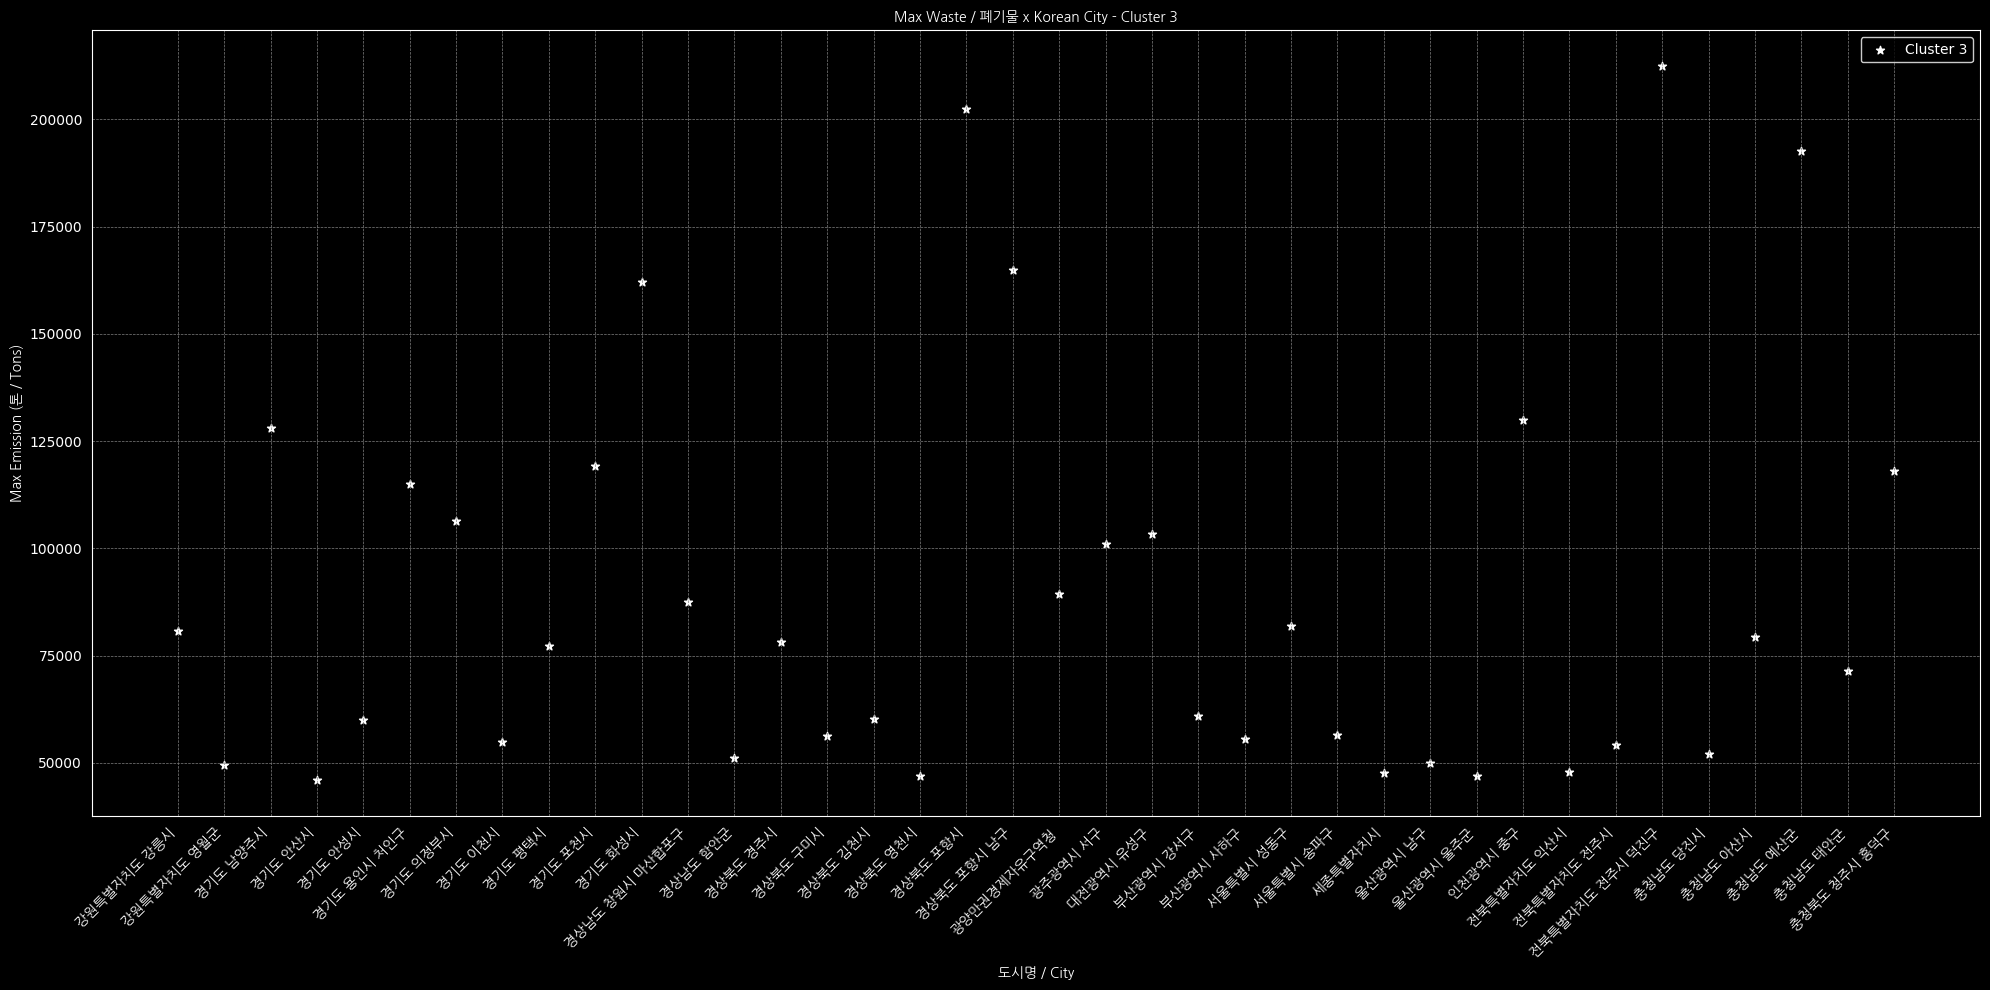

In [31]:
# Single cluster to visualize
selected_cluster = 3

# Filter data for only this cluster
cluster_data = df_clusterC[df_clusterC["Cluster"] == selected_cluster]

# Get max emission values for each city in the cluster
max_values_cluster = (
    cluster_data.groupby("기초시군구(관할관청)")["연간배출량(톤)"]
    .max()
    .reset_index()
)

cities_cluster = max_values_cluster["기초시군구(관할관청)"]
max_waste_cluster = max_values_cluster["연간배출량(톤)"]

# Scatter plot for the selected cluster
plt.figure(figsize=(20, 10), facecolor='black')  
ax = plt.gca()  
ax.set_facecolor('black') 


plt.scatter(cities_cluster, max_waste_cluster, label=f'Cluster {selected_cluster}', 
            marker='*', color='white')


plt.xlabel("도시명 / City", fontproperties=font, color='white')
plt.ylabel("Max Emission (톤 / Tons)", fontproperties=font, color='white')
plt.title(f"Max Waste / 폐기물 x Korean City - Cluster {selected_cluster}", fontproperties=font, color='white')


plt.xticks(ticks=range(len(cities_cluster)), labels=cities_cluster, 
           fontproperties=font, fontsize=10, rotation=45, ha='right', color='white')
plt.yticks(color='white')

# Grid and Borders
plt.grid(color='gray', linestyle='--', linewidth=0.5)  
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')

plt.legend(facecolor='black', edgecolor='white', labelcolor='white')

plt.tight_layout()
plt.show()

In [35]:
unique_clusters = df_clusterC['Cluster'].unique()
print(f"Unique Clusters: {unique_clusters}")

Unique Clusters: [0 3 4 1 2 5]


In [76]:
max_values_by_city = df_clusterC.groupby(['Cluster', '기초시군구(관할관청)'])['연간배출량(톤)'].max().reset_index()

for cluster in sorted(df_clusterC["Cluster"].unique()):  # Iterate through sorted unique clusters
    print(f"\n🔹 Cluster {cluster} - Max Waste per City:")
    
    cluster_data = max_values_by_city[max_values_by_city["Cluster"] == cluster]
    
    for _, row in cluster_data.iterrows():
        print(f"City: {row['기초시군구(관할관청)']}, Max Emission: {row['연간배출량(톤)']:.2f} tons")


🔹 Cluster 0 - Max Waste per City:
City: 강원특별자치도 강릉시, Max Emission: 19676.32 tons
City: 강원특별자치도 고성군, Max Emission: 96.00 tons
City: 강원특별자치도 동해시, Max Emission: 1922.30 tons
City: 강원특별자치도 삼척시, Max Emission: 30099.29 tons
City: 강원특별자치도 속초시, Max Emission: 4413.33 tons
City: 강원특별자치도 양구군, Max Emission: 1851.05 tons
City: 강원특별자치도 양양군, Max Emission: 1074.52 tons
City: 강원특별자치도 영월군, Max Emission: 4840.56 tons
City: 강원특별자치도 원주시, Max Emission: 34119.40 tons
City: 강원특별자치도 인제군, Max Emission: 2502.53 tons
City: 강원특별자치도 정선군, Max Emission: 21703.48 tons
City: 강원특별자치도 철원군, Max Emission: 190.24 tons
City: 강원특별자치도 춘천시, Max Emission: 585.25 tons
City: 강원특별자치도 태백시, Max Emission: 2457.54 tons
City: 강원특별자치도 평창군, Max Emission: 1539.85 tons
City: 강원특별자치도 홍천군, Max Emission: 3772.15 tons
City: 강원특별자치도 화천군, Max Emission: 1039.57 tons
City: 강원특별자치도 횡성군, Max Emission: 1213.92 tons
City: 경기도 가평군, Max Emission: 2664.15 tons
City: 경기도 고양시 덕양구, Max Emission: 15996.93 tons
City: 경기도 고양시 일산동구, Max Emission: 23740.50 tons
